In [4]:
# Implementation for the hexagonal lattice


from tqdm import tqdm
import numpy as np
from PIL import Image
from IPython.display import display
import numba
import matplotlib
matplotlib.use('Agg')  # Set non-interactive backend
import matplotlib.pyplot as plt
import os

def initialize_grid(beta, size=101):
    """
    Initialize the hexagonal grid with given size and fill it with beta values.

    Parameters:
        beta (float): Background level, initial water density in the surrounding atmosphere.
        size (int): Size of the grid.

    Returns:
        grid (ndarray): Initialized grid.
    """
    grid = np.full((size, size), beta)
    mid = size // 2
    grid[mid][mid] = 1  # Seed/mineral around which the snowflake forms
    return grid

def plot_grid(grid, saveas=None, show=False):
    """
    Plot the grid and save it as an image.

    Parameters:
        grid (ndarray): Grid to plot.
        saveas (str): File path to save the image (optional).
        show (bool): Whether to display the plot (optional).
    """
    n = grid.shape[0]
    max_val = np.max(grid)
    inverted_grid = max_val - grid

    plt.figure(figsize=(8, 8))
    plt.imshow(inverted_grid, cmap='Greys', interpolation='nearest')
    plt.title("Density Display")

    if saveas:
        plt.savefig(saveas)
    if show:
        plt.show(block=True)

@numba.jit(nopython=True)
def convert(grid):
    """
    Convert the grid to a snowflake grid where cells with values >= 1 are considered solid.

    Parameters:
        grid (ndarray): Input grid.

    Returns:
        snowflake_grid (ndarray): Snowflake grid.
    """
    n = grid.shape[0]
    snowflake_grid = np.zeros((n, n))
    for i, row in enumerate(grid):
        for j, element in enumerate(row):
            if element >= 1:
                snowflake_grid[i][j] = 1
    return snowflake_grid

@numba.jit(nopython=True)
def calculate_average(grid, alpha):
    """
    Calculate the average value of each gas cell based on its neighbors.

    Parameters:
        grid (ndarray): Input grid.
        alpha (float): Diffusion constant.

    Returns:
        averaged_grid (ndarray): Grid with averaged values.
    """
    n = grid.shape[0]
    averaged_grid = np.zeros((n, n))
    for i, row in enumerate(grid):
        for j, element in enumerate(row):
            averaged_grid[i][j] += (1 - alpha * 0.5) * element

            averaged_grid[(i + 1) % n][j] += alpha / 12 * element
            averaged_grid[i][(j - 1) % n] += alpha / 12 * element
            averaged_grid[i][(j + 1) % n] += alpha / 12 * element
            averaged_grid[(i - 1) % n][j % n] += alpha / 12 * element

            if i % 2 == 0:
                averaged_grid[(i + 1) % n][(j - 1) % n] += alpha / 12 * element
                averaged_grid[(i - 1) % n][(j - 1) % n] += alpha / 12 * element
            else:
                averaged_grid[(i + 1) % n][(j + 1) % n] += alpha / 12 * element
                averaged_grid[(i - 1) % n][(j + 1) % n] += alpha / 12 * element
    return averaged_grid

@numba.jit(nopython=True)
def perform_timestep(grid, alpha):
    """
    Perform a discrete update on the grid according to the diffusion equation.

    Parameters:
        grid (ndarray): Input grid.
        alpha (float): Diffusion constant.

    Returns:
        updated_grid (ndarray): Updated grid.
    """
    n = grid.shape[0]
    grid_is_receptive = np.zeros((n, n))
    for i, row in enumerate(grid):
        for j, element in enumerate(row):
            if element >= 1:
                grid_is_receptive[i][j] = 1
                grid_is_receptive[(i + 1) % n][j] = 1
                grid_is_receptive[(i - 1) % n][j] = 1
                grid_is_receptive[i][(j - 1) % n] = 1
                grid_is_receptive[i][(j + 1) % n] = 1
                if i % 2 == 0:
                    grid_is_receptive[(i + 1) % n][(j - 1) % n] = 1
                    grid_is_receptive[(i - 1) % n][(j - 1) % n] = 1
                else:
                    grid_is_receptive[(i + 1) % n][(j + 1) % n] = 1
                    grid_is_receptive[(i - 1) % n][(j + 1) % n] = 1
    
    grid_receptive = np.zeros((n, n))
    grid_non_receptive = np.zeros((n, n))
    for i, row in enumerate(grid):
        for j, element in enumerate(row):
            if grid_is_receptive[i][j] == 1:
                grid_receptive[i][j] = element
            else:
                grid_non_receptive[i][j] = element
    
    grid_non_receptive = calculate_average(grid_non_receptive, alpha)
    return grid_receptive + grid_non_receptive

@numba.jit(nopython=True)
def out_of_bounds(grid):
    """
    Check if the snowflake is too big for the grid.

    Parameters:
        grid (ndarray): Input grid.

    Returns:
        bool: True if snowflake is too big, False otherwise.
    """
    n = grid.shape[0]
    mid = (n - 1) // 2
    one_ninth = n // 9
    if grid[mid][one_ninth] >= 1:
        return True
    return False

@numba.jit(nopython=True)
def pad_grid(grid, beta, pad_size=20):
    """
    Increase the grid size by adding padding.

    Parameters:
        grid (ndarray): Input grid.
        beta (float): Background level to fill the padding.
        pad_size (int): Size of padding.

    Returns:
        bigger_grid (ndarray): Grid with padding.
    """
    n = grid.shape[0]
    bigger_grid = np.full((n + 2 * pad_size, n + 2 * pad_size), beta)
    for i in range(n):
        for j in range(n):
            bigger_grid[i + pad_size][j + pad_size] = grid[i][j]
    return bigger_grid

def correct_image(path, show=True):
    """
    Load an image and stretch it horizontally.

    Parameters:
        path (str): File path of the image.
    """
    image = Image.open(path)
    width = image.size[0]
    new_width = int(width / (np.sqrt(3) / 2))
    stretched_image = image.resize((new_width, image.size[1]))
    stretched_image.save(path)
    if show:
        stretched_image.show()

def generate_snowflake_pngs(alpha, beta, iterations, size, out=False):
    """
    Generate PNG images of the snowflake as it grows.

    Parameters:
        alpha (float): Diffusion constant.
        beta (float): Background level, initial water density in the surrounding atmosphere.
        iterations (int): Maximum number of iterations for the simulation.
        size (int): Size of the frame.
    """
    dir_name = f"snowflake_pngs_alpha={alpha}_beta={beta}"
    os.makedirs(dir_name, exist_ok=True)

    grid = initialize_grid(beta, size)
    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            grid = perform_timestep(grid, alpha)

            if i % 50 == 0:
                if out_of_bounds(grid):
                    break

                n = grid.shape[0]

                #uncomment this to observe the progression of the crystal
                
                #saveas = f"{dir_name}/snowflake_alpha={alpha}_beta={beta}_iter={i}_n={n}.png"
                #plot_grid(grid, saveas, show=False)
                #correct_image(saveas, show=False)

            pbar.update(1)
        pbar.update(10000)

    n = grid.shape[0]
    saveas = f"snowflake_alpha={alpha}_beta={beta}_iter={iterations - 1}_n={n}.png"
    plot_grid(grid, saveas)
    correct_image(saveas, show=False)

    if out:
        image = Image.open(saveas)
        display(image)

11000it [00:07, 1540.83it/s]                                                                                                                                                                                    


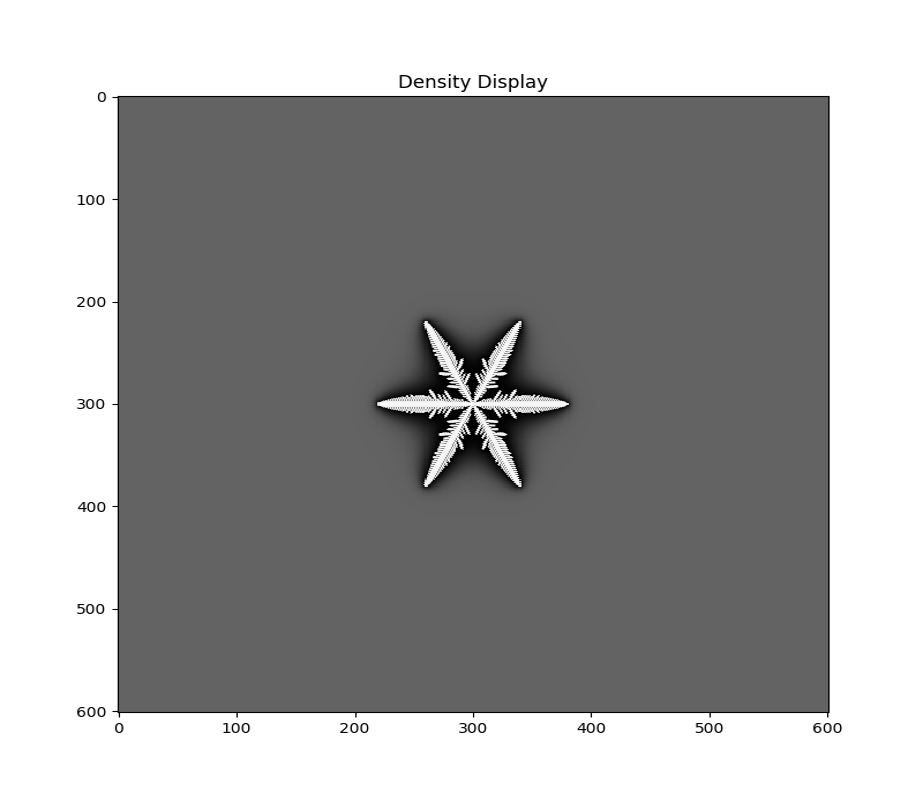

In [7]:
alpha = 2.6
beta = 0.35
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1554.01it/s]                                                                                                                                                                                    


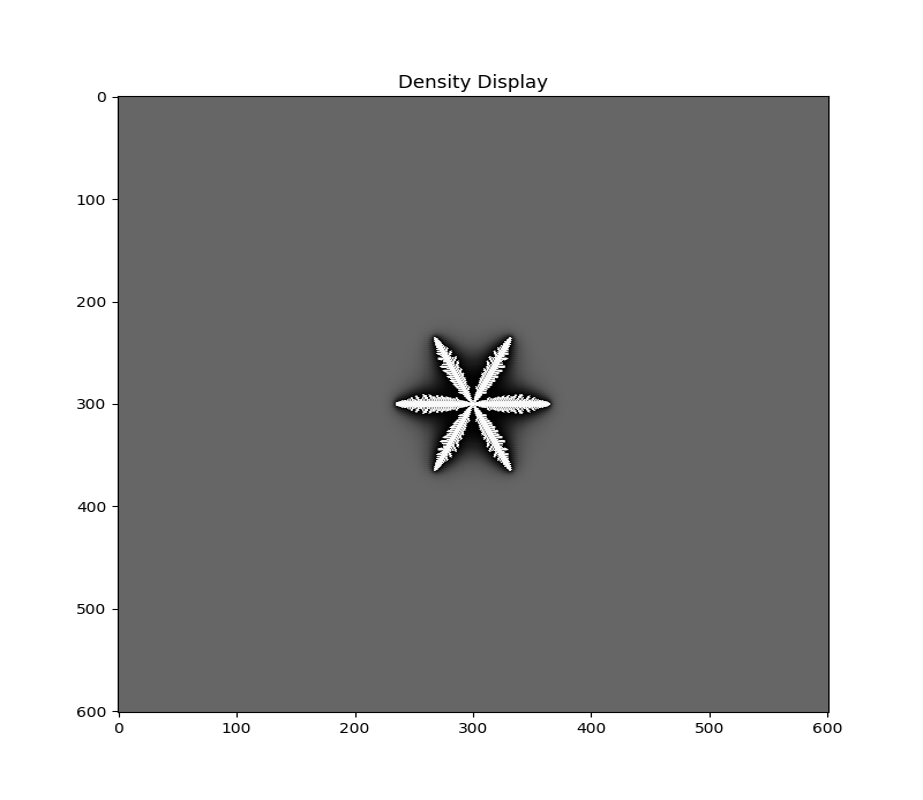

In [10]:
alpha = 2.0
beta = 0.35
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1536.94it/s]                                                                                                                                                                                    


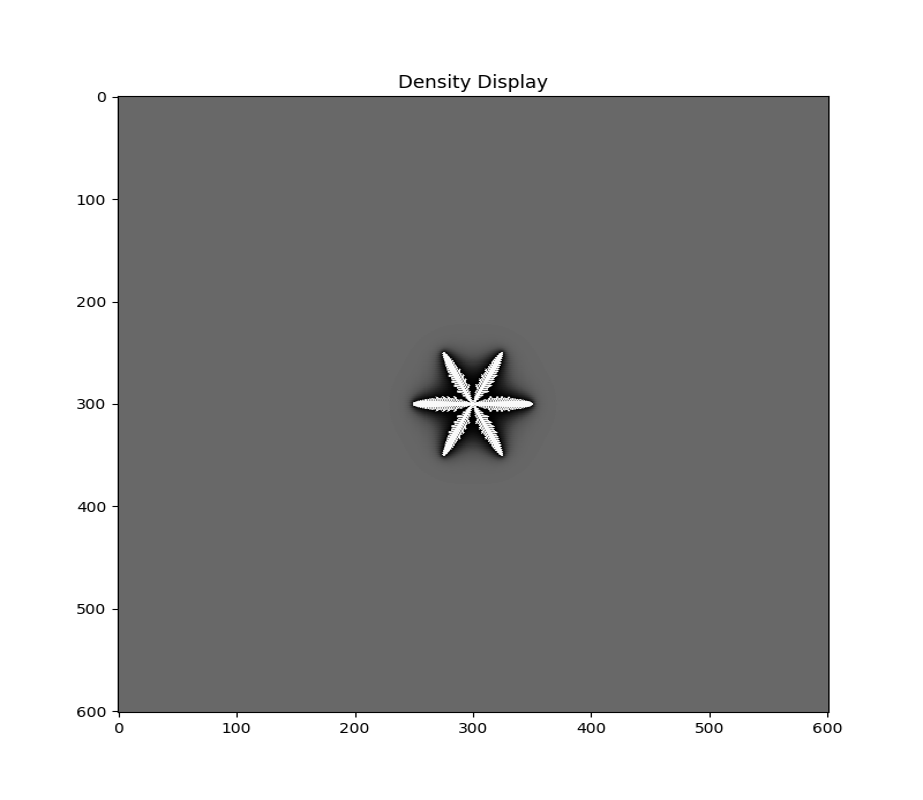

In [11]:
alpha = 1.5
beta = 0.35
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1550.64it/s]                                                                                                                                                                                    


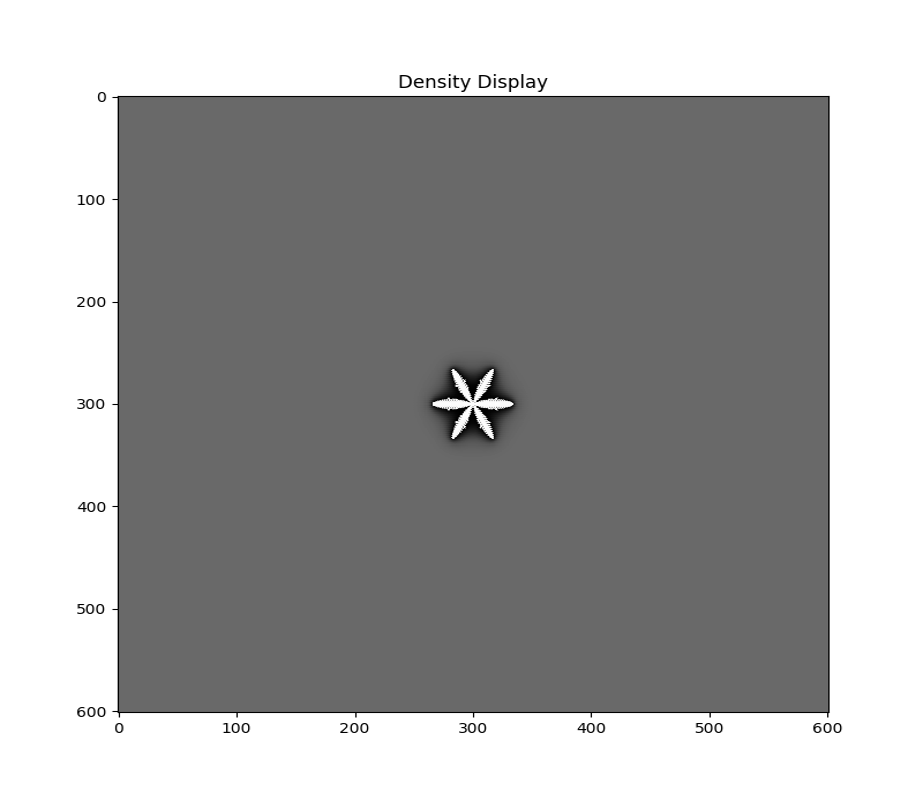

In [12]:
alpha = 1.0
beta = 0.35
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1567.52it/s]                                                                                                                                                                                    


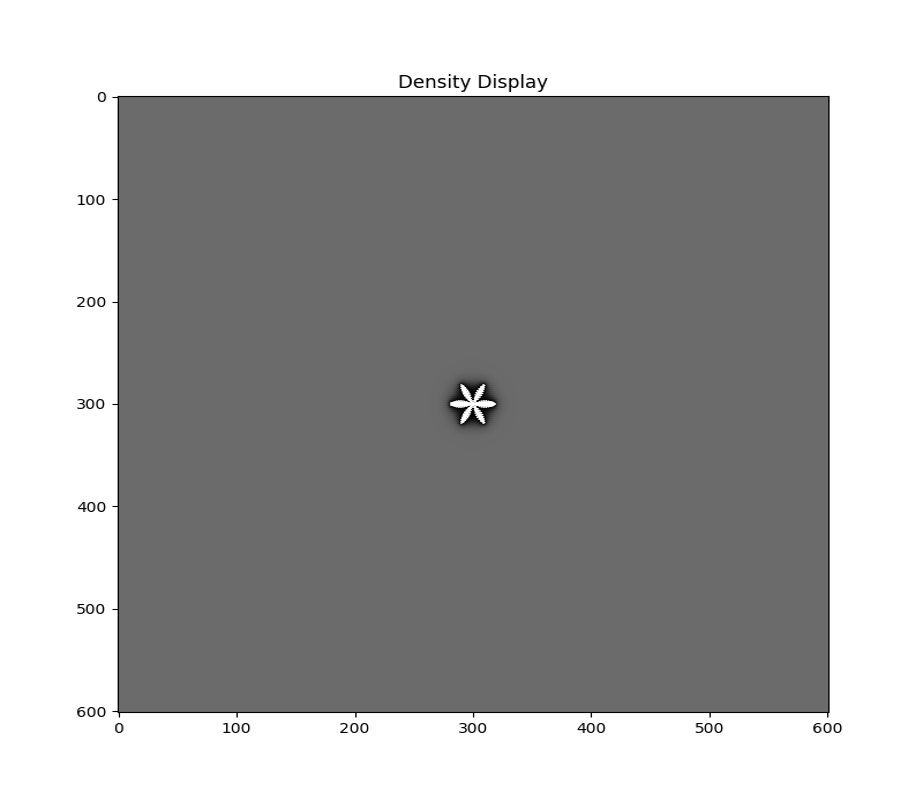

In [13]:
alpha = 0.5
beta = 0.35
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1534.89it/s]                                                                                                                                                                                    


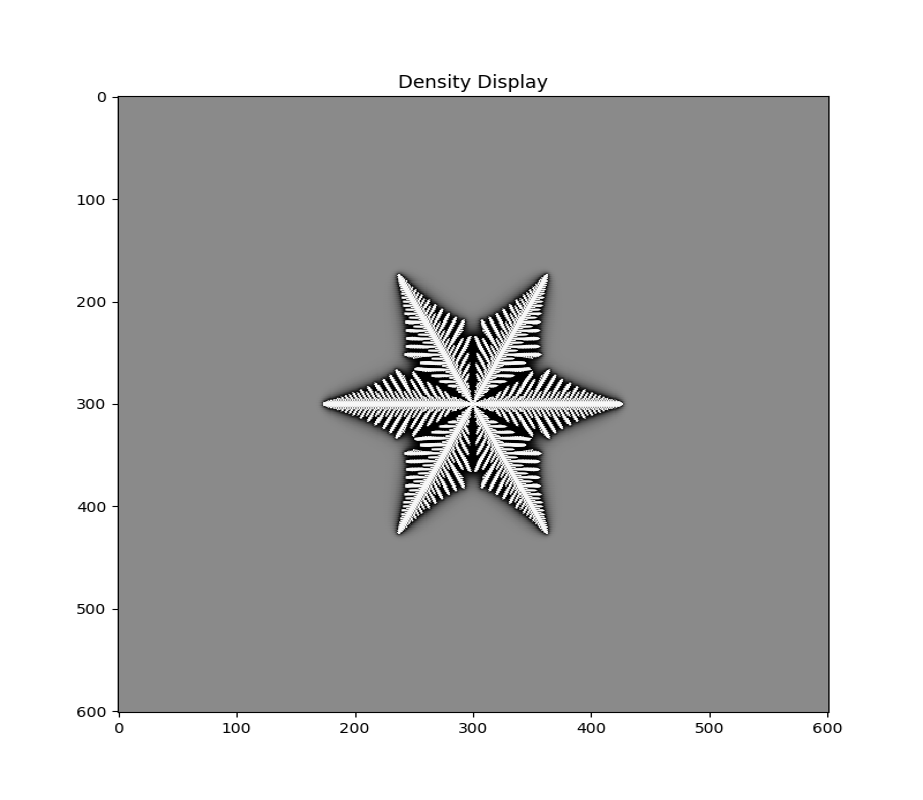

In [14]:
alpha = 1.5
beta = 0.5
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

10500it [00:03, 2859.40it/s]                                                                                                                                                                                    


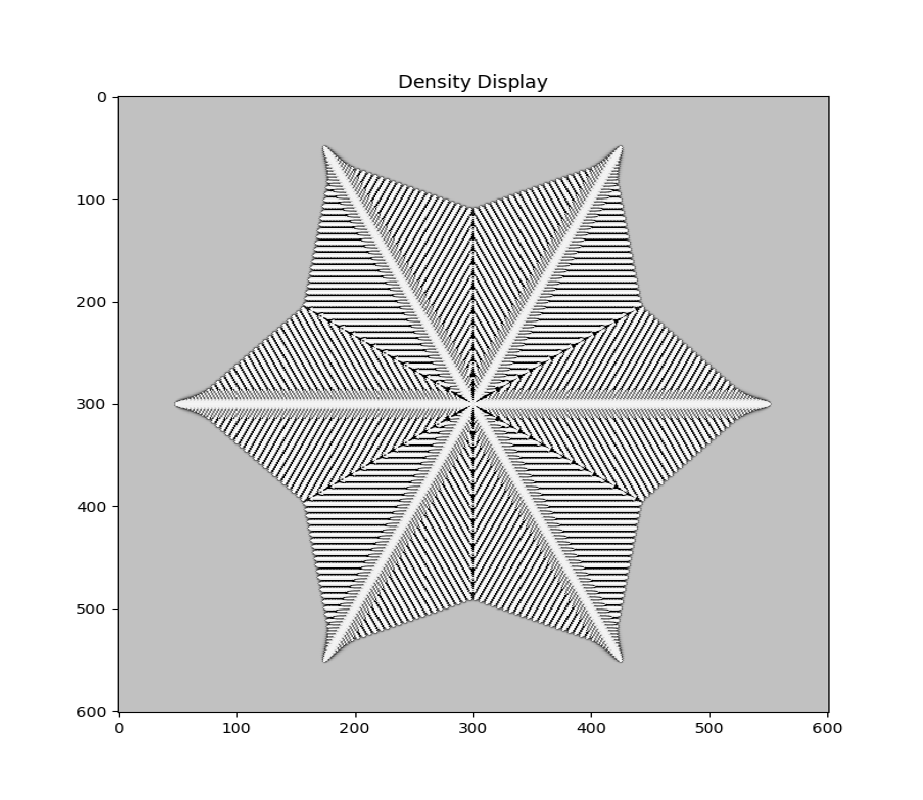

In [15]:
alpha = 1.5
beta = 0.75
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1543.22it/s]                                                                                                                                                                                    


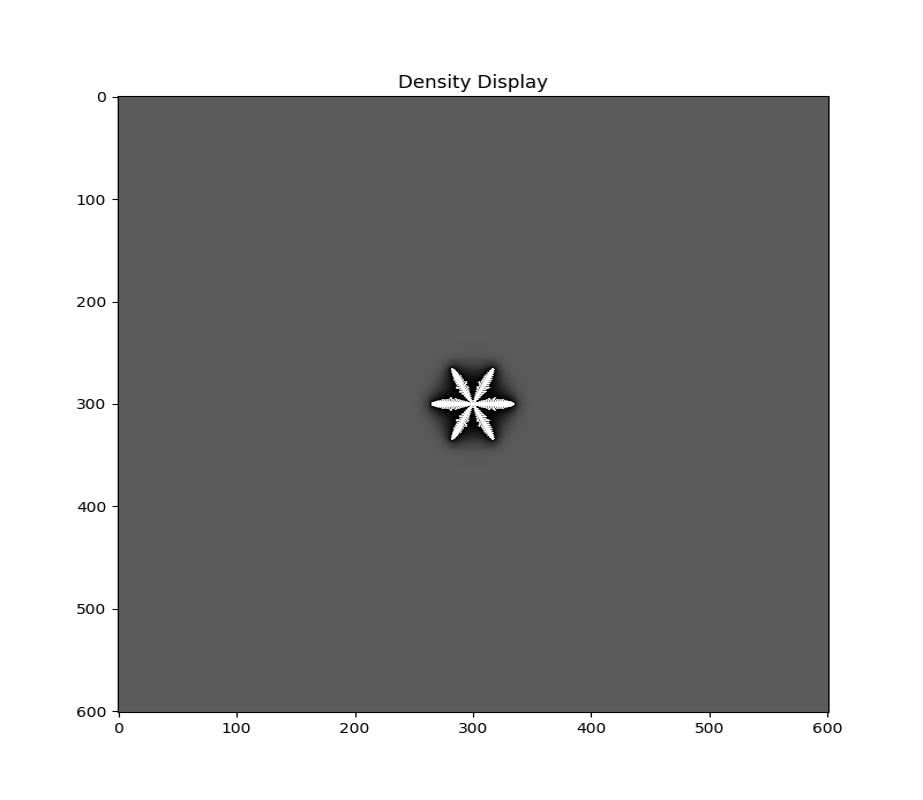

In [16]:
alpha = 1.5
beta = 0.3
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1567.42it/s]                                                                                                                                                                                    


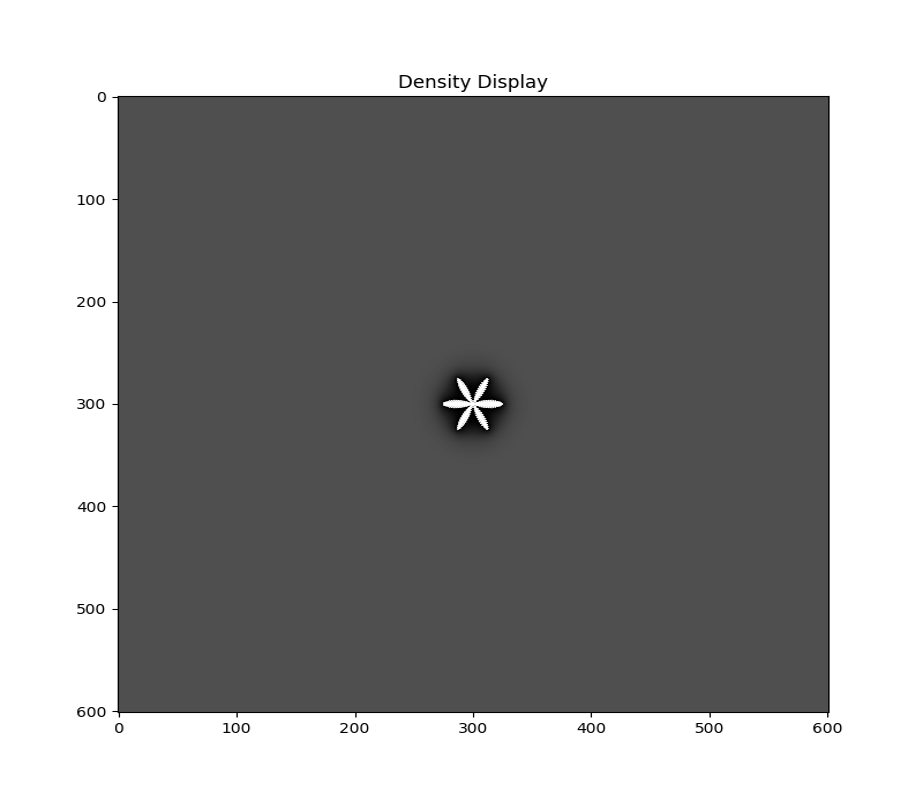

In [17]:
alpha = 1.5
beta = 0.25
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

12000it [00:13, 865.49it/s]                                                                                                                                                                                     


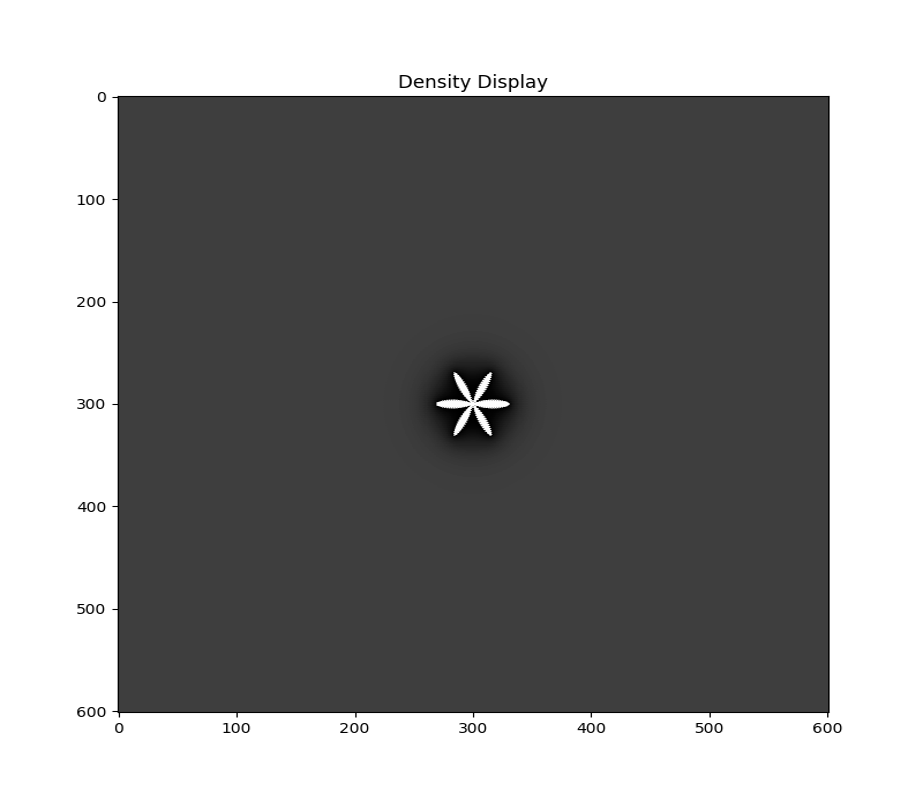

In [19]:
alpha = 1.5
beta = 0.2
max_iter = 2000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

14000it [00:28, 493.91it/s]                                                                                                                                                                                     


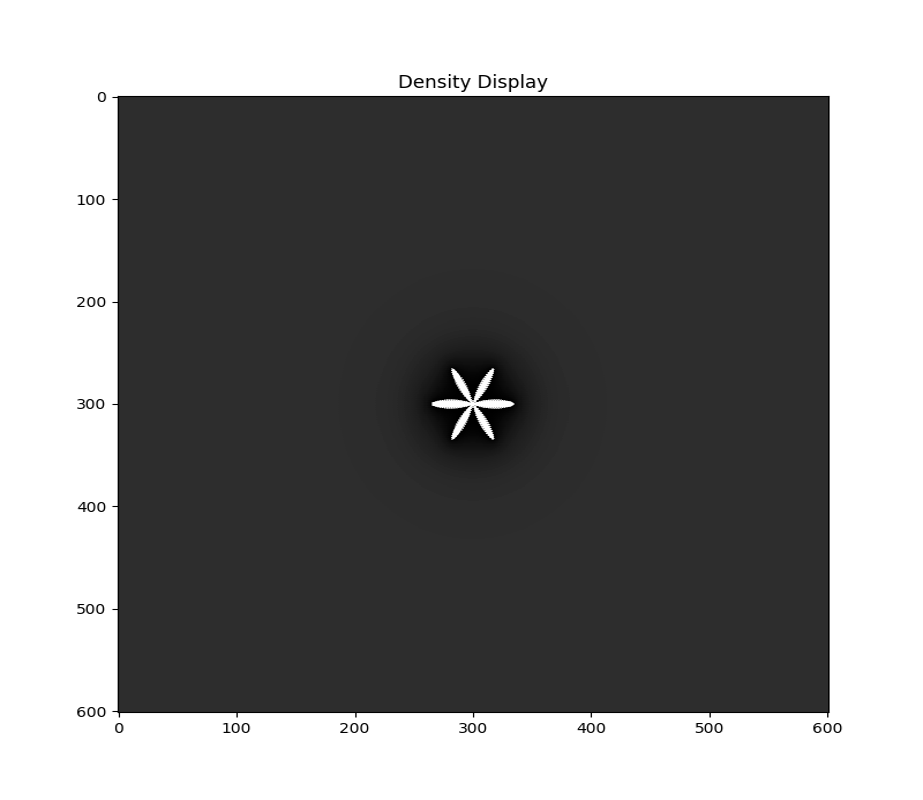

In [20]:
alpha = 1.5
beta = 0.15
max_iter = 4000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:08, 1372.39it/s]                                                                                                                                                                                    


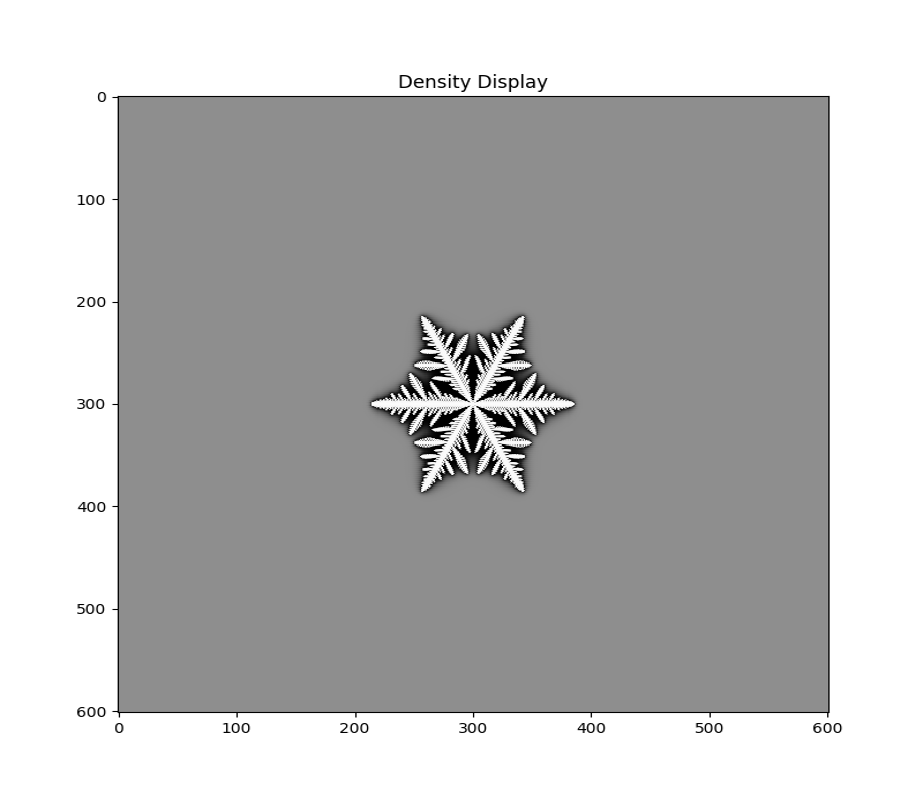

In [21]:
alpha = 1
beta = 0.5
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

10950it [00:06, 1592.05it/s]                                                                                                                                                                                    


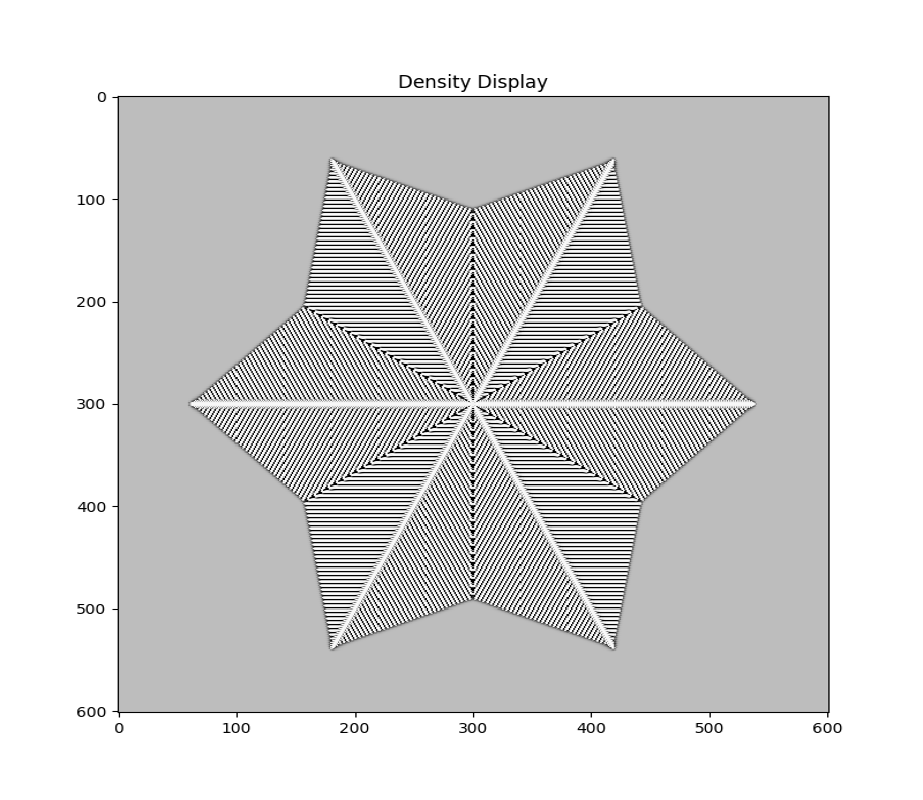

In [22]:
alpha = 1
beta = 0.7
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

13000it [00:22, 573.34it/s]                                                                                                                                                                                     
C:\Users\gabri\AppData\Local\Temp\ipykernel_37336\2470083215.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


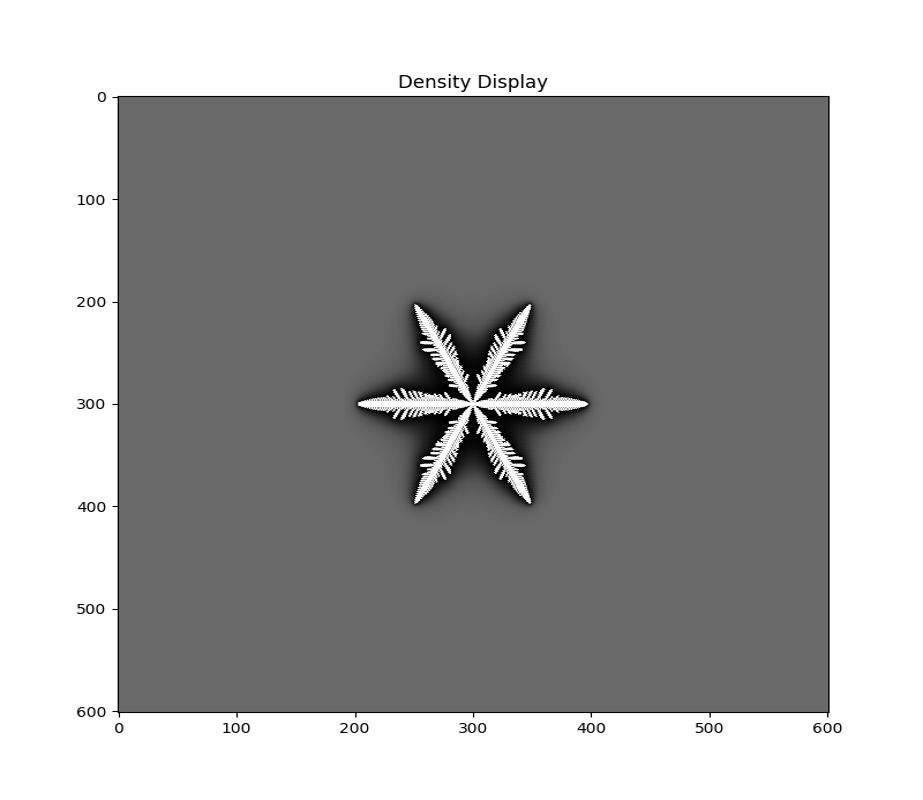

In [25]:
alpha = 1
beta = 0.35
max_iter = 3000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1403.95it/s]                                                                                                                                                                                    


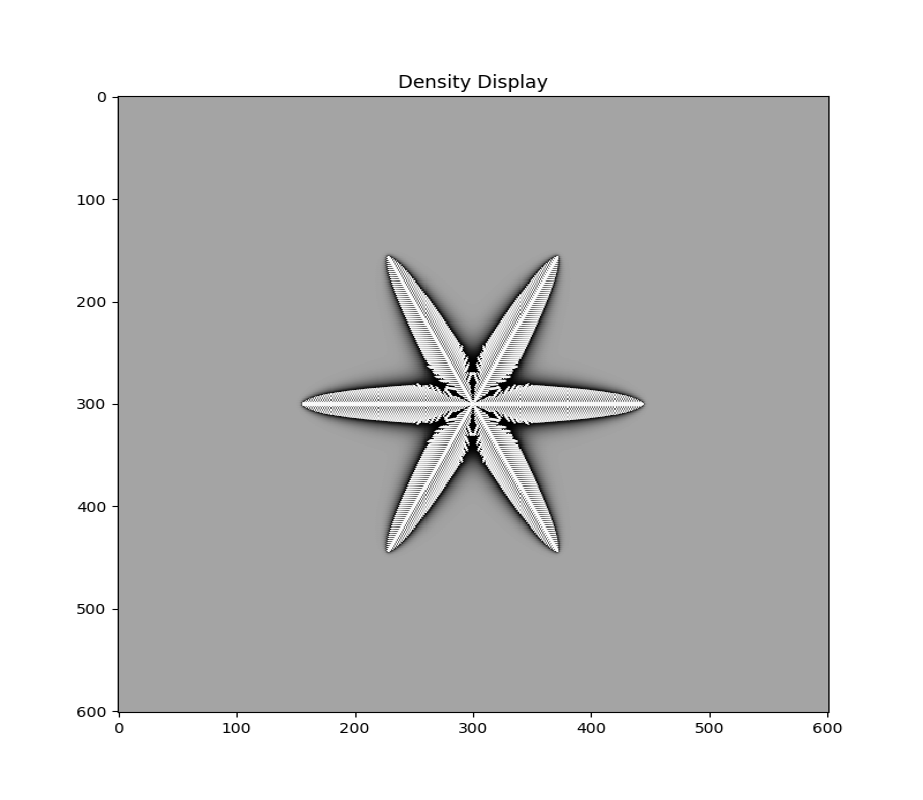

In [24]:
alpha = 1
beta = 0.6
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1444.44it/s]                                                                                                                                                                                    


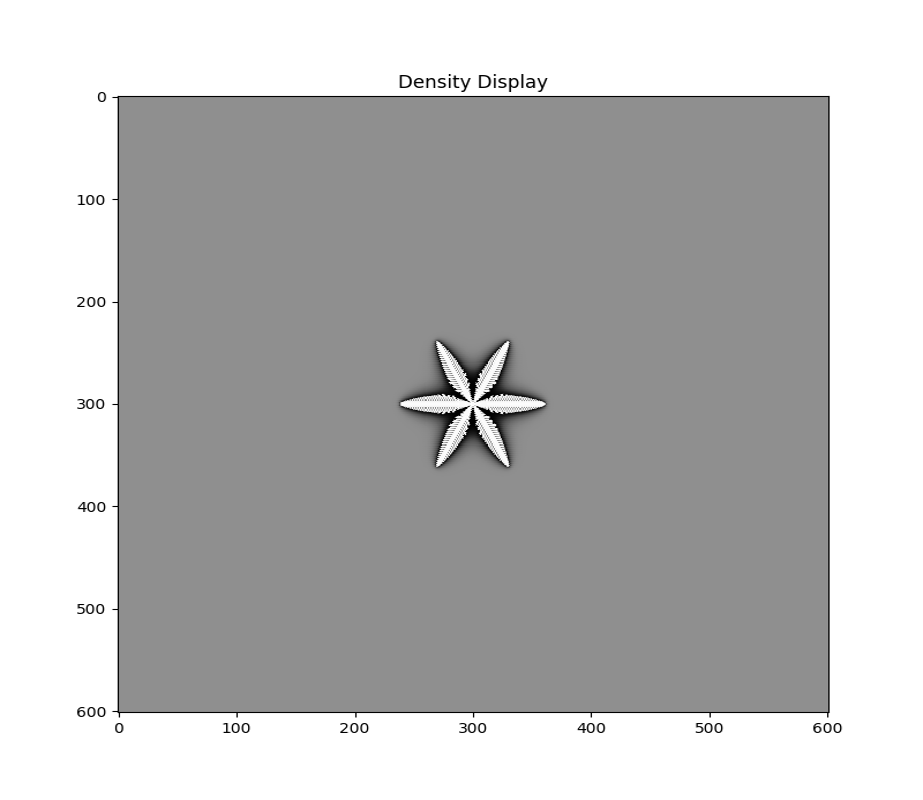

In [26]:
alpha = 0.7
beta = 0.5
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

11000it [00:07, 1384.19it/s]                                                                                                                                                                                    


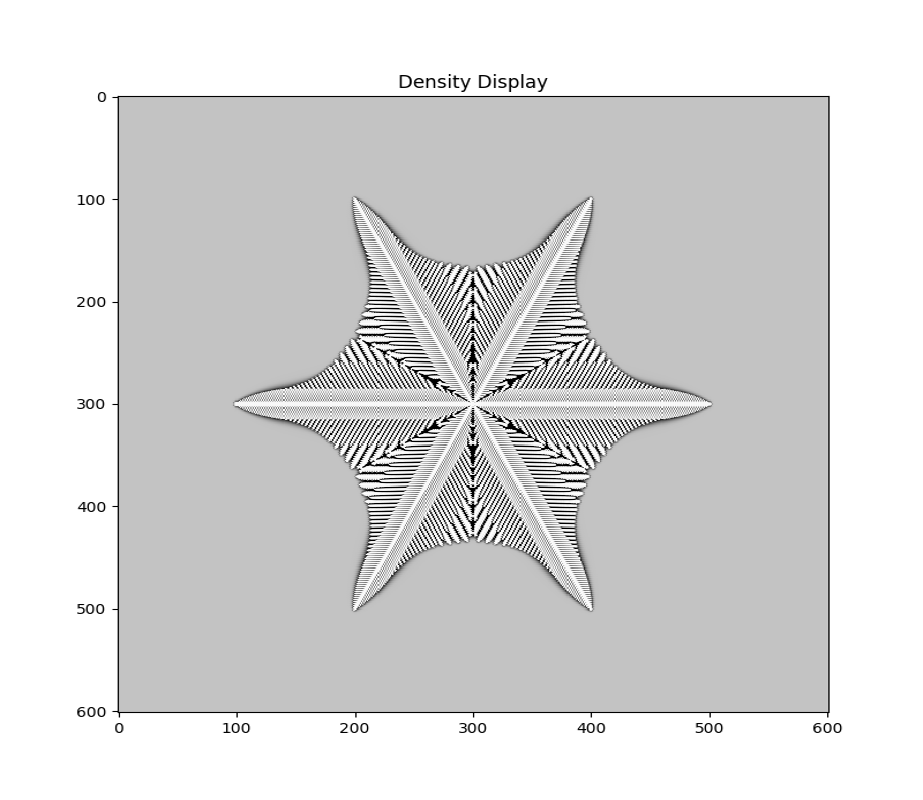

In [27]:
alpha = 0.7
beta = 0.7
max_iter = 1000
size = 601

generate_snowflake_pngs(alpha, beta, max_iter, size, out=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

def fractal_dimension(Z, threshold=0.9):
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        return len(np.where((S > 0) & (S < k*k))[0])

    Z = (Z < threshold)

    p = min(Z.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))

    sizes = 2**np.arange(n, 1, -1)

    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# Load an image file
im = imread('image.png', as_gray=True)
im = resize(im, (im.shape[0] // 2, im.shape[1] // 2))

print("Fractal dimension of image: ", fractal_dimension(im))